# Image Classification using Convolutional Neural Networks

This Notebook uses the concepts and steps used by https://github.com/bentrevett/pytorch-image-classification/blob/master/2_lenet.ipynb
The goal is to build a Image Classification Model by using a Convolution Neural Network.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time
import os

## Pre-Processing Steps

### Setting a random seed for reproducability

In [2]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

### Determining the mean and std of the training dataset

In [11]:
ROOT = '.data'
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

mean = train_data.data.numpy().mean() / 255
std = train_data.data.numpy().std() / 255

print('Calculated mean: ', mean)
print('Calculated std:', std)

Calculated mean:  0.1306604762738429
Calculated std: 0.30810780385646264


### Define the training and test transformations

We introdue certain random abnormalities into the training set 

In [33]:
train_transforms = transforms.Compose([
    transforms.RandomRotation(5, fill=(0,)),
    transforms.RandomCrop(28, padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[mean], std=[std])
])

### Loading training and test datasets

In [34]:
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

### Creating the validation set
Validation set is always created from the training dataset.
Validation set is taken as 10% of the training set

In [35]:
RATIO = 0.9
n_train_examples = int(len(train_data) * RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, validation_data = data.random_split(train_data, [n_train_examples,n_valid_examples])

Currently validation set has the same transformation as train set. However, we want validation set to resemble the test dataset. Hence, here we change its tranformation to that of the test set

In [36]:
validation_data = copy.deepcopy(validation_data)
validation_data.dataset.transform = test_transforms

In [37]:
print("Training:", len(train_data))
print("Validation:", len(validation_data))
print("Test:", len(test_data))

Training: 54000
Validation: 6000
Test: 10000


### Creating Dataloaders/Iterators
Finally, the last step in pre-processing is to create iterators for each data set we will be using.
This allows for lazy loading such that only batch size is laded in memory at a time. We select our batch_size to be 64 and enable shuffling only in the training set.

In [38]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(validation_data,
                                 batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Defining the Model
The MNIST Dataset consists of 28x28 sized images. <br>
1) The first layer of this CNN is going to take in an input of [1,28,28]. The first layer is a convolutional layer and is going consist of 6 filters (out_channels) and kernel size of 5. Once the image passes through this layer it will be of [6,24,24]. <br>
2) The second layer is going to be a Max Pooling Layer with a filter size of 2.This is going to transform the image into half the height and width giving [6,12,12]. <br>
3) This is then passed through a ReLU activation function. <br>
4) We now pass the data through a second Convolutional Layer which will consist of 16 filters (hence giving an output of depth 16). Filter will have a heightxwidthxdepth of 5x5x6. The resulting output will be [16,8,8] <br>
5) We pass this through another Max Pooling Layer with filter size 2 making the output of size [16,4,4] <br>
6) Finally we pass this through the ReLU function <br>
7) We flatten this output and pass this through 3 linear layers, ReLU follows each layer except the last. This is done so as to weigh the features further so that a better predcition can be made.


In [39]:
class MyCNN(nn.Module):
    def __init__(self, output_dimension):
        super().__init__() # MyCNN inherits from nn.Module

        self.conv1 = nn.Conv2d(in_channels=1, # number of input
                               out_channels=6, # number of output
                               kernel_size=5) # size of the filter

        self.conv2 = nn.Conv2d(in_channels=6,
                               out_channels=16,
                               kernel_size=5)

        self.lin1 = nn.Linear(16*4*4, 120)
        self.lin2 = nn.Linear(120, 84)
        self.lin3 = nn.Linear(84, output_dimension)

    def forward(self, x):
        # batch size = [1,28,28]
        x = self.conv1(x)
        # batch size = [6,24,24]
        x = F.max_pool2d(x, kernel_size=2)
        # batch size = [6,12,12]
        x = F.relu(x)

        x = self.conv2(x)
        # batch size = [16,8,8]
        x = F.max_pool2d(x, kernel_size=2)
        # batch size = [16,4,4]
        x = F.relu(x)
        x = x.view(x.shape[0], -1)
        # batch size = [256]

        h = x

        x = self.lin1(x)
        # batch size = [120]
        x = F.relu(x)
        x = self.lin2(x)
        # batch size = [84]
        x = F.relu(x)
        x = self.lin3(x)
        # batch size = [output_dimension]

        return x, h

In [40]:
OUTPUT_DIM = 10
model = MyCNN(OUTPUT_DIM)

### Count the parameters on which to train

In [41]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("The model has ", count_parameters(model),"trainable parameters")

The model has  44426 trainable parameters


## Training the Model

### Define the Optimizer

In [42]:
optimizer = optim.Adam(model.parameters())

### Define the Loss Function - Cross Entropy

In [43]:
criterion = nn.CrossEntropyLoss()

### Define Device allocation

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Place model and Criterion on the device

In [45]:
model = model.to(device)
criterion = criterion.to(device)

### Define a function to calculate the Accuracy

In [46]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float()/y.shape[0]
    return acc

### Train Epochs

In [47]:
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x,y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss/len(iterator), epoch_acc/len(iterator)

### Function for model evaluation

In [48]:
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y= y.to(device)

            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        return epoch_loss / len(iterator), epoch_acc / len(iterator)

### Function to calculate time taken for each epoch

In [49]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_time*60))
    return elapsed_mins, elapsed_secs

### Begin training the model

In [50]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut2-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print("Epoch ", epoch, "| Epoch Time: ", epoch_mins," mins ", epoch_secs," secs")
    print("Train Loss: ", train_loss, "| Train Accuracy: ", train_acc)
    print("validation Loss: ", valid_loss, "| Validation Accuracy: ", valid_acc)

Epoch  0 | Epoch Time:  0  mins  -2603  secs
Train Loss:  0.37843330829267463 | Train Accuracy:  0.8804551737992119
validation Loss:  0.09139691458697966 | Validation Accuracy:  0.9699689714198417
Epoch  1 | Epoch Time:  0  mins  -3291  secs
Train Loss:  0.12735088810024528 | Train Accuracy:  0.9604623321249587
validation Loss:  0.0820696628652513 | Validation Accuracy:  0.9743461881546264
Epoch  2 | Epoch Time:  1  mins  -3795  secs
Train Loss:  0.09667875071418124 | Train Accuracy:  0.969780558870302
validation Loss:  0.05963195435346124 | Validation Accuracy:  0.9821586881546264
Epoch  3 | Epoch Time:  1  mins  -3860  secs
Train Loss:  0.0791995801763737 | Train Accuracy:  0.9756615323619255
validation Loss:  0.06147989483074622 | Validation Accuracy:  0.9798869680851063
Epoch  4 | Epoch Time:  1  mins  -3879  secs
Train Loss:  0.07117517051875692 | Train Accuracy:  0.9778152152684063
validation Loss:  0.04566146935425461 | Validation Accuracy:  0.9851507094312222
Epoch  5 | Epoch T

Test result shows an accuracy of 99.22% and a Loss of just 0.024

In [51]:
model.load_state_dict(torch.load('tut2-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print("Test Loss: ", test_loss, "| Test Accuracy: ", test_acc)

Test Loss:  0.024420944193155547 | Test Accuracy:  0.9922372611464968


## Examining the Model

We will examine the model by plotting a confusion matrix, seeing which incorrect examples our model was most confident about.

In [52]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)

            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [53]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [54]:
def plot_confusion_matrix(labels, pred_labels):
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(1,1,1)
    cm = confusion_matrix(labels, pred_labels)
    cm = ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

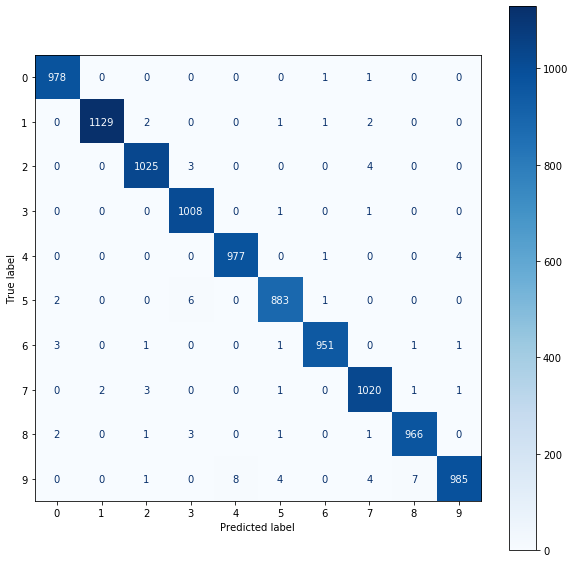

In [55]:
plot_confusion_matrix(labels, pred_labels)

The highest problem seems to be with true 9 being prediced as 4 and also 9 being predicted as 8

In [56]:
corrects = torch.eq(labels, pred_labels)

In [57]:
incorrect_examples = []

In [58]:
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True, key= lambda x: torch.max(x[2], dim=0).values)

In [59]:
def plot_most_incorrect(incorrect, n_images):
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28,28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

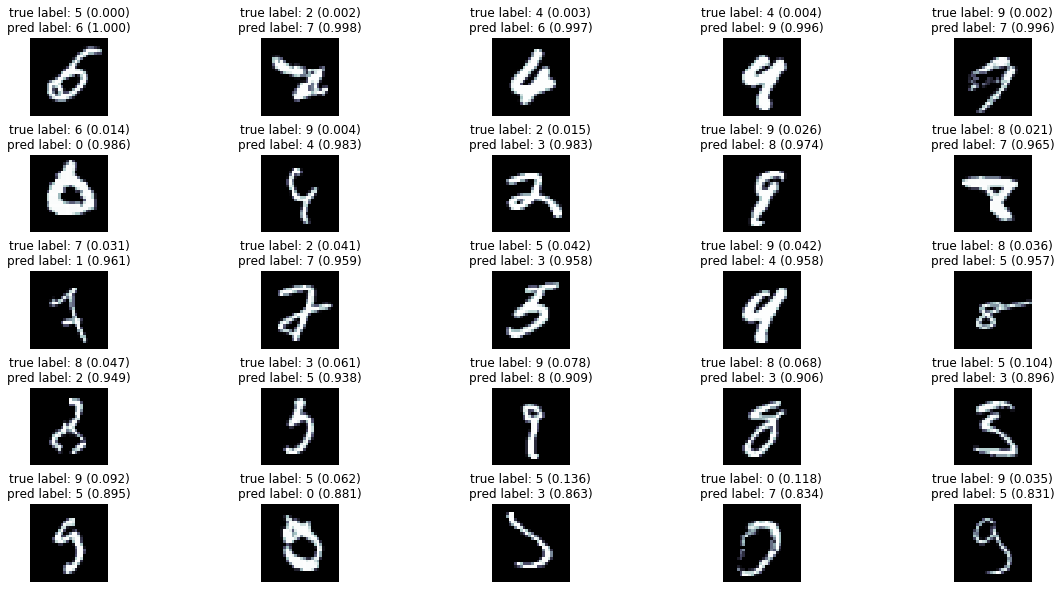

In [60]:
N_IMAGES = 25
plot_most_incorrect(incorrect_examples, N_IMAGES)